# 🎯 Estratégia de Máximo RECALL para Data Linkage
## Objetivo: Encontrar o Máximo de Pares Verdadeiros

Este notebook implementa uma estratégia agressiva para **maximizar a sensibilidade** do linkage, aceitando um aumento de falsos positivos em troca de capturar mais pares verdadeiros.

### Técnicas Implementadas:
1. **Ensemble com Soft Voting** - Combina múltiplos modelos
2. **SMOTE + Undersampling** - Balanceamento agressivo
3. **Threshold Otimizado para Recall** - Ponto de corte baixo
4. **Cost-Sensitive Learning** - Penalização maior para falsos negativos
5. **Cascade Classifier** - Múltiplas etapas de classificação
6. **Feature Engineering Extensivo** - Novas variáveis discriminativas
7. **Neural Network com Class Weights** - Deep Learning com balanceamento

In [1]:
# Instalação de dependências
!pip install -q pandas numpy scikit-learn xgboost lightgbm imbalanced-learn matplotlib seaborn tensorflow keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    VotingClassifier, AdaBoostClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, f1_score, precision_score, recall_score,
    average_precision_score, make_scorer
)
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


## 1. Carregamento e Preparação Avançada dos Dados

In [3]:
# Carregar dados
from pathlib import Path

def find_data_path(filename: str = 'COMPARADORSEMIDENT.csv') -> Path:
    for base in (Path.cwd(), *Path.cwd().parents):
        candidate = base / 'data' / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Nao foi possivel localizar data/{filename}. CWD={Path.cwd()}"
    )

DATA_PATH = find_data_path()
df = pd.read_csv(DATA_PATH, sep=';', low_memory=False)
print(f"Lendo arquivo: {DATA_PATH.resolve()}")

# Limpar nomes das colunas
def clean_col(col):
    return col.split(',')[0] if ',' in col else col
df.columns = [clean_col(c) for c in df.columns]

# Converter colunas numéricas
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        except:
            pass

# Target
df['TARGET'] = (df['PAR'].isin([1, 2])).astype(int)

print(f"Dataset: {df.shape[0]:,} registros")
print(f"Pares verdadeiros: {df['TARGET'].sum()} ({df['TARGET'].mean()*100:.2f}%)")

Lendo arquivo: D:\git\phd-research\data\COMPARADORSEMIDENT.csv


Dataset: 61,696 registros
Pares verdadeiros: 247 (0.40%)


In [4]:
# Feature Engineering Extensivo para Maximizar Recall

# Features base
SCORE_COLS = [
    'NOME prim frag igual', 'NOME ult frag igual', 'NOME qtd frag iguais',
    'NOME qtd frag raros', 'NOME qtd frag comuns', 'NOME qtd frag muito parec', 'NOME qtd frag abrev',
    'NOMEMAE prim frag igual', 'NOMEMAE ult frag igual', 'NOMEMAE qtd frag iguais',
    'NOMEMAE qtd frag raros', 'NOMEMAE qtd frag comuns', 'NOMEMAE qtd frag muito parec', 'NOMEMAE qtd frag abrev',
    'DTNASC dt iguais', 'DTNASC dt ap 1digi', 'DTNASC dt inv dia', 'DTNASC dt inv mes', 'DTNASC dt inv ano',
    'CODMUNRES uf igual', 'CODMUNRES local igual', 'CODMUNRES local prox',
    'ENDERECO via igual', 'ENDERECO via prox', 'ENDERECO numero igual',
    'ENDERECO compl prox', 'ENDERECO texto prox', 'ENDERECO tokens jacc',
    'nota final'
]

available_cols = [c for c in SCORE_COLS if c in df.columns]
X = df[available_cols].fillna(0).copy()

print(f"Features base: {len(available_cols)}")

# ============================================
# FEATURE ENGINEERING AVANÇADO
# ============================================

# 1. Scores agregados
X['nome_total'] = X['NOME prim frag igual'] + X['NOME ult frag igual'] + X['NOME qtd frag iguais'] + X['NOME qtd frag muito parec']
X['mae_total'] = X['NOMEMAE prim frag igual'] + X['NOMEMAE ult frag igual'] + X['NOMEMAE qtd frag iguais']
X['dtnasc_total'] = X['DTNASC dt iguais'] + X['DTNASC dt ap 1digi'] * 0.8 + X['DTNASC dt inv dia'] * 0.5
X['endereco_total'] = X['ENDERECO via igual'] + X['ENDERECO via prox'] * 0.7 + X['ENDERECO texto prox']
X['local_total'] = X['CODMUNRES local igual'] + X['CODMUNRES local prox'] * 0.5

# 2. Score ponderado customizado (otimizado para recall)
X['score_recall'] = (
    X['NOME qtd frag iguais'] * 3.0 +
    X['NOME prim frag igual'] * 2.0 +
    X['DTNASC dt iguais'] * 2.5 +
    X['DTNASC dt ap 1digi'] * 2.0 +  # Aumentar peso para datas aproximadas
    X['NOMEMAE qtd frag iguais'] * 1.5 +
    X['CODMUNRES local igual'] * 1.0 +
    X['ENDERECO via igual'] * 0.5
)

# 3. Interações multiplicativas
X['nome_x_dtnasc'] = X['NOME qtd frag iguais'] * (X['DTNASC dt iguais'] + X['DTNASC dt ap 1digi'])
X['nome_x_mae'] = X['NOME qtd frag iguais'] * X['NOMEMAE qtd frag iguais']
X['nome_x_local'] = X['NOME qtd frag iguais'] * X['CODMUNRES local igual']
X['dtnasc_x_local'] = X['dtnasc_total'] * X['local_total']
X['nome_x_endereco'] = X['nome_total'] * X['endereco_total']

# 4. Flags binários (relaxados para capturar mais casos)
X['nome_bom'] = (X['NOME qtd frag iguais'] >= 0.7).astype(int)  # Relaxado de 0.95
X['nome_prim_ok'] = (X['NOME prim frag igual'] >= 0.8).astype(int)
X['dtnasc_ok'] = ((X['DTNASC dt iguais'] == 1) | (X['DTNASC dt ap 1digi'] == 1)).astype(int)  # Aceita aproximado
X['dtnasc_parcial'] = ((X['DTNASC dt inv dia'] == 1) | (X['DTNASC dt inv mes'] == 1)).astype(int)
X['mae_presente'] = (X['NOMEMAE qtd frag iguais'] > 0.3).astype(int)  # Relaxado
X['local_ok'] = (X['CODMUNRES local igual'] >= 0.8).astype(int)

# 5. Contagem de evidências positivas
X['evidencias_positivas'] = (
    X['nome_bom'] + X['nome_prim_ok'] + X['dtnasc_ok'] + 
    X['dtnasc_parcial'] + X['mae_presente'] + X['local_ok']
)

# 6. Score de confiança mínima (para catch-all)
X['min_score_nome'] = X[['NOME prim frag igual', 'NOME ult frag igual', 'NOME qtd frag iguais']].min(axis=1)
X['max_score_dtnasc'] = X[['DTNASC dt iguais', 'DTNASC dt ap 1digi']].max(axis=1)

# 7. Razões e proporções
X['ratio_nome_mae'] = X['nome_total'] / (X['mae_total'] + 0.1)
X['ratio_nome_nota'] = X['nome_total'] / (X['nota final'] + 0.1)

# 8. Variáveis do contexto (situação de encerramento)
X['obito_sinan'] = df['C_SITUENCE'].isin([3, 4]).astype(int)
X['obito_tb'] = (df['C_SITUENCE'] == 3).astype(int)

# 9. Diferença de datas (proxy para verificar consistência temporal)
df['R_DT_ANO'] = df['R_DTNASC'].astype(str).str[:4].astype(float)
df['C_DT_ANO'] = df['C_DTNASC'].astype(str).str[:4].astype(float)
X['diff_ano_nasc'] = np.abs(df['R_DT_ANO'] - df['C_DT_ANO']).fillna(99)
X['diff_ano_ok'] = (X['diff_ano_nasc'] <= 5).astype(int)  # Aceita até 5 anos de diferença

# 10. Polinômios de features importantes
X['nome_squared'] = X['NOME qtd frag iguais'] ** 2
X['dtnasc_squared'] = X['DTNASC dt iguais'] ** 2
X['nota_squared'] = X['nota final'] ** 2

print(f"\nTotal de features após engineering: {X.shape[1]}")
print(f"Novas features criadas: {X.shape[1] - len(available_cols)}")

Features base: 29



Total de features após engineering: 58
Novas features criadas: 29


In [5]:
# Preparar dados
y = df['TARGET'].copy()

# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Guardar índices originais
train_idx = X_train.index
test_idx = X_test.index

print(f"Treino: {len(X_train):,} ({y_train.sum()} pares)")
print(f"Teste: {len(X_test):,} ({y_test.sum()} pares)")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Treino: 43,187 (173 pares)
Teste: 18,509 (74 pares)


## 2. Balanceamento Agressivo com SMOTE + Variantes

In [6]:
# Testar diferentes estratégias de balanceamento
print("Aplicando técnicas de balanceamento...\n")

# 1. SMOTE padrão
smote = SMOTE(random_state=42, k_neighbors=3)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE: {len(y_smote):,} amostras (pares: {y_smote.sum():,})")

# 2. BorderlineSMOTE (foca nos casos de fronteira)
bsmote = BorderlineSMOTE(random_state=42, k_neighbors=3)
X_bsmote, y_bsmote = bsmote.fit_resample(X_train, y_train)
print(f"BorderlineSMOTE: {len(y_bsmote):,} amostras (pares: {y_bsmote.sum():,})")

# 3. ADASYN (adaptativo)
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print(f"ADASYN: {len(y_adasyn):,} amostras (pares: {y_adasyn.sum():,})")

# 4. SMOTE + Tomek Links (remove ruído)
smote_tomek = SMOTETomek(random_state=42)
X_smtomek, y_smtomek = smote_tomek.fit_resample(X_train, y_train)
print(f"SMOTETomek: {len(y_smtomek):,} amostras (pares: {y_smtomek.sum():,})")

# 5. Oversampling extremo (ratio 1:1)
smote_extreme = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=3)
X_extreme, y_extreme = smote_extreme.fit_resample(X_train, y_train)
print(f"SMOTE Extremo (1:1): {len(y_extreme):,} amostras (pares: {y_extreme.sum():,})")

Aplicando técnicas de balanceamento...



SMOTE: 86,028 amostras (pares: 43,014)
BorderlineSMOTE: 86,028 amostras (pares: 43,014)


ADASYN: 86,027 amostras (pares: 43,013)


SMOTETomek: 86,026 amostras (pares: 43,013)


SMOTE Extremo (1:1): 86,028 amostras (pares: 43,014)


## 3. Modelos Otimizados para Recall

In [7]:
# Função para calcular métricas
def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name, threshold=0.5):
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_te)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    return {
        'name': model_name,
        'precision': precision_score(y_te, y_pred),
        'recall': recall_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
        'auc_roc': roc_auc_score(y_te, y_proba),
        'auc_pr': average_precision_score(y_te, y_proba),
        'y_proba': y_proba,
        'model': model
    }

In [8]:
# Definir modelos com configurações otimizadas para recall
results = []

# 1. Random Forest com class_weight extremo
print("Treinando modelos...\n")

rf_recall = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 500},  # Peso extremo para classe minoritária
    random_state=42,
    n_jobs=-1
)
res = evaluate_model(rf_recall, X_train.values, y_train, X_test.values, y_test, 
                     'RF Class Weight Extremo', threshold=0.3)
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

# 2. Random Forest + SMOTE
rf_smote = RandomForestClassifier(
    n_estimators=300, max_depth=12, random_state=42, n_jobs=-1
)
res = evaluate_model(rf_smote, X_smote.values, y_smote, X_test.values, y_test,
                     'RF + SMOTE', threshold=0.3)
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

# 3. Random Forest + BorderlineSMOTE
rf_bsmote = RandomForestClassifier(
    n_estimators=300, max_depth=12, random_state=42, n_jobs=-1
)
res = evaluate_model(rf_bsmote, X_bsmote.values, y_bsmote, X_test.values, y_test,
                     'RF + BorderlineSMOTE', threshold=0.3)
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

# 4. Gradient Boosting com sample_weight
gb_recall = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
# Criar sample weights
sample_weights = np.where(y_smote == 1, 10, 1)
gb_recall.fit(X_smote.values, y_smote, sample_weight=sample_weights)
y_proba_gb = gb_recall.predict_proba(X_test.values)[:, 1]
y_pred_gb = (y_proba_gb >= 0.3).astype(int)
res = {
    'name': 'GB + SMOTE + Sample Weights',
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'auc_roc': roc_auc_score(y_test, y_proba_gb),
    'auc_pr': average_precision_score(y_test, y_proba_gb),
    'y_proba': y_proba_gb,
    'model': gb_recall
}
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

# 5. AdaBoost (bom para recall)
ada_recall = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)
res = evaluate_model(ada_recall, X_smote.values, y_smote, X_test.values, y_test,
                     'AdaBoost + SMOTE', threshold=0.3)
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

Treinando modelos...



RF Class Weight Extremo: Recall=0.9324, Precision=0.9324


RF + SMOTE: Recall=0.9595, Precision=0.8161


RF + BorderlineSMOTE: Recall=0.9595, Precision=0.8765


GB + SMOTE + Sample Weights: Recall=0.9595, Precision=0.9342


AdaBoost + SMOTE: Recall=1.0000, Precision=0.0537


In [9]:
# 6. Neural Network com class_weight
print("\nTreinando Neural Network...")

mlp_recall = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Usar SMOTE extremo para NN
X_train_nn = scaler.fit_transform(X_extreme)
X_test_nn = scaler.transform(X_test)

mlp_recall.fit(X_train_nn, y_extreme)
y_proba_nn = mlp_recall.predict_proba(X_test_nn)[:, 1]
y_pred_nn = (y_proba_nn >= 0.25).astype(int)  # Threshold baixo

res = {
    'name': 'MLP + SMOTE Extremo (th=0.25)',
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1': f1_score(y_test, y_pred_nn),
    'auc_roc': roc_auc_score(y_test, y_proba_nn),
    'auc_pr': average_precision_score(y_test, y_proba_nn),
    'y_proba': y_proba_nn,
    'model': mlp_recall
}
results.append(res)
print(f"{res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")


Treinando Neural Network...


MLP + SMOTE Extremo (th=0.25): Recall=0.9459, Precision=0.6481


## 4. Ensemble com Soft Voting (Maximizar Recall)

In [10]:
# Criar ensemble de todos os modelos treinados
print("Construindo Ensemble para Máximo Recall...\n")

# Ensemble 1: Voting com modelos diversos
ensemble_recall = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=12, 
                                      class_weight={0:1, 1:300}, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=150, max_depth=5, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=150, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ],
    voting='soft',
    weights=[2, 1, 1, 1]  # Mais peso para RF
)

ensemble_recall.fit(X_smote.values, y_smote)
y_proba_ens = ensemble_recall.predict_proba(X_test.values)[:, 1]

# Testar diferentes thresholds
print("Performance do Ensemble com diferentes thresholds:")
for th in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]:
    y_pred_ens = (y_proba_ens >= th).astype(int)
    rec = recall_score(y_test, y_pred_ens)
    prec = precision_score(y_test, y_pred_ens)
    f1 = f1_score(y_test, y_pred_ens)
    print(f"  Threshold {th}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

# Usar threshold que maximize recall com precision > 1%
best_th_recall = 0.15
y_pred_ens_final = (y_proba_ens >= best_th_recall).astype(int)

res = {
    'name': f'Ensemble Soft Voting (th={best_th_recall})',
    'precision': precision_score(y_test, y_pred_ens_final),
    'recall': recall_score(y_test, y_pred_ens_final),
    'f1': f1_score(y_test, y_pred_ens_final),
    'auc_roc': roc_auc_score(y_test, y_proba_ens),
    'auc_pr': average_precision_score(y_test, y_proba_ens),
    'y_proba': y_proba_ens,
    'model': ensemble_recall
}
results.append(res)
print(f"\n>>> {res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

Construindo Ensemble para Máximo Recall...



Performance do Ensemble com diferentes thresholds:
  Threshold 0.15: Recall=1.0000, Precision=0.1486, F1=0.2587
  Threshold 0.2: Recall=1.0000, Precision=0.2395, F1=0.3864
  Threshold 0.25: Recall=0.9865, Precision=0.2819, F1=0.4384
  Threshold 0.3: Recall=0.9865, Precision=0.3188, F1=0.4818
  Threshold 0.35: Recall=0.9595, Precision=0.4733, F1=0.6339
  Threshold 0.4: Recall=0.9595, Precision=0.6762, F1=0.7933

>>> Ensemble Soft Voting (th=0.15): Recall=1.0000, Precision=0.1486


## 5. Cascade Classifier (Múltiplos Estágios)

In [11]:
# Cascade: Primeiro estágio filtra, segundo estágio refina
print("Construindo Cascade Classifier...\n")

# Estágio 1: Modelo com recall muito alto (aceita muitos falsos positivos)
stage1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight={0: 1, 1: 1000},
    random_state=42
)
stage1.fit(X_smote.values, y_smote)
y_proba_s1 = stage1.predict_proba(X_test.values)[:, 1]
y_pred_s1 = (y_proba_s1 >= 0.1).astype(int)  # Threshold muito baixo

print(f"Estágio 1: Recall={recall_score(y_test, y_pred_s1):.4f}, " +
      f"Candidatos passados: {y_pred_s1.sum()}")

# Estágio 2: Refinar apenas os candidatos do estágio 1
mask_s1 = y_pred_s1 == 1
if mask_s1.sum() > 0:
    X_stage2 = X_test.values[mask_s1]
    y_stage2_true = y_test.values[mask_s1]
    
    stage2 = GradientBoostingClassifier(
        n_estimators=150, max_depth=5, random_state=42
    )
    stage2.fit(X_smote.values, y_smote)
    y_proba_s2 = stage2.predict_proba(X_stage2)[:, 1]
    y_pred_s2 = (y_proba_s2 >= 0.2).astype(int)
    
    # Combinar predições
    y_pred_cascade = np.zeros(len(y_test))
    y_pred_cascade[mask_s1] = y_pred_s2
    
    y_proba_cascade = np.zeros(len(y_test))
    y_proba_cascade[mask_s1] = y_proba_s2
    
    res = {
        'name': 'Cascade (2 estágios)',
        'precision': precision_score(y_test, y_pred_cascade),
        'recall': recall_score(y_test, y_pred_cascade),
        'f1': f1_score(y_test, y_pred_cascade),
        'auc_roc': roc_auc_score(y_test, y_proba_cascade) if y_proba_cascade.max() > 0 else 0,
        'auc_pr': average_precision_score(y_test, y_proba_cascade) if y_proba_cascade.max() > 0 else 0,
        'y_proba': y_proba_cascade,
        'model': (stage1, stage2)
    }
    results.append(res)
    print(f"\n>>> {res['name']}: Recall={res['recall']:.4f}, Precision={res['precision']:.4f}")

Construindo Cascade Classifier...



Estágio 1: Recall=1.0000, Candidatos passados: 5526



>>> Cascade (2 estágios): Recall=0.9189, Precision=0.9067


## 6. Comparação e Seleção do Melhor Modelo para Recall

In [12]:
# Criar DataFrame de resultados
df_results = pd.DataFrame([{
    'Modelo': r['name'],
    'Recall': r['recall'],
    'Precision': r['precision'],
    'F1': r['f1'],
    'AUC-ROC': r['auc_roc'],
    'AUC-PR': r['auc_pr']
} for r in results])

df_results = df_results.sort_values('Recall', ascending=False)

print("\n" + "="*90)
print("RANKING DE MODELOS POR RECALL")
print("="*90)
print(df_results.to_string(index=False))

# Identificar melhor modelo
best_recall_idx = df_results['Recall'].idxmax()
best_model_name = df_results.loc[best_recall_idx, 'Modelo']
best_result = [r for r in results if r['name'] == best_model_name][0]

print(f"\n🏆 MELHOR MODELO PARA RECALL: {best_model_name}")
print(f"   Recall: {best_result['recall']:.4f}")
print(f"   Precision: {best_result['precision']:.4f}")


RANKING DE MODELOS POR RECALL
                        Modelo   Recall  Precision       F1  AUC-ROC   AUC-PR
Ensemble Soft Voting (th=0.15) 1.000000   0.148594 0.258741 0.999614 0.963004
              AdaBoost + SMOTE 1.000000   0.053701 0.101928 0.999849 0.985116
                    RF + SMOTE 0.959459   0.816092 0.881988 0.999886 0.976871
          RF + BorderlineSMOTE 0.959459   0.876543 0.916129 0.999927 0.984691
   GB + SMOTE + Sample Weights 0.959459   0.934211 0.946667 0.999925 0.986654
 MLP + SMOTE Extremo (th=0.25) 0.945946   0.648148 0.769231 0.997722 0.948542
       RF Class Weight Extremo 0.932432   0.932432 0.932432 0.999924 0.982501
          Cascade (2 estágios) 0.918919   0.906667 0.912752 0.999856 0.983266

🏆 MELHOR MODELO PARA RECALL: Ensemble Soft Voting (th=0.15)
   Recall: 1.0000
   Precision: 0.1486


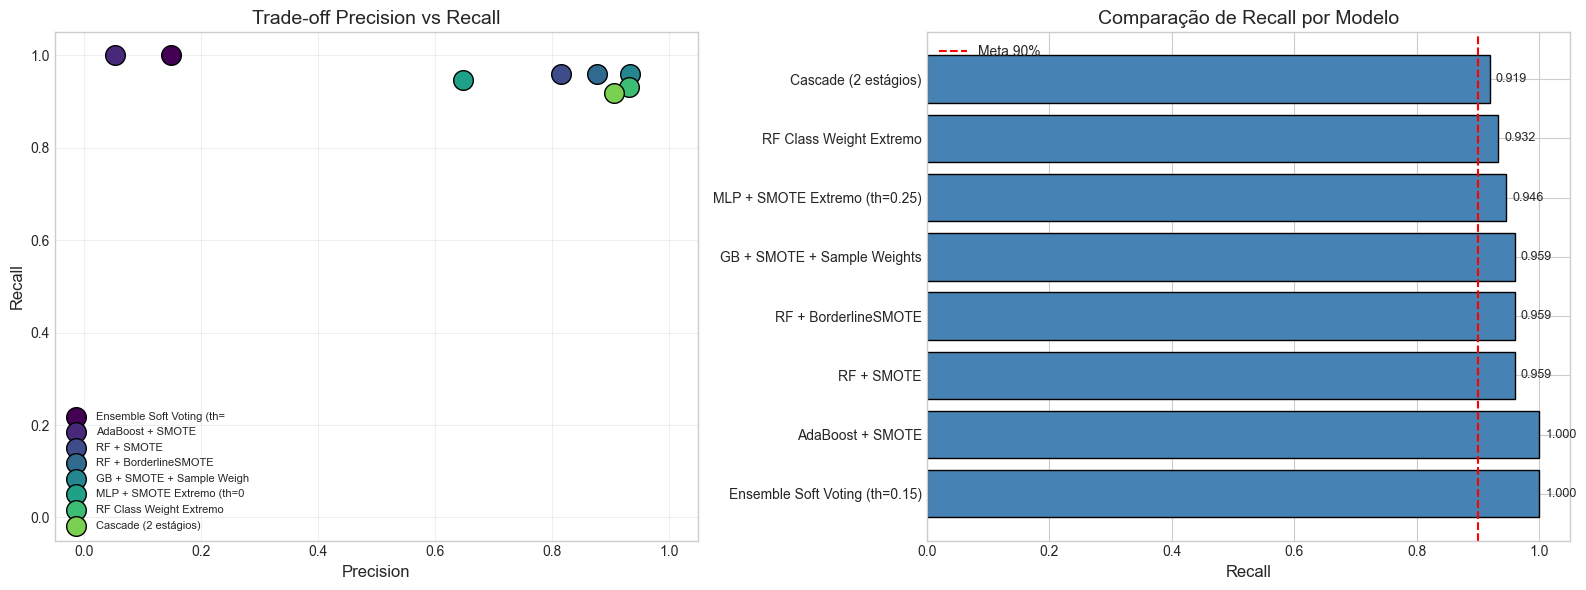

In [13]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Recall vs Precision
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(df_results)))
for idx, (_, row) in enumerate(df_results.iterrows()):
    ax1.scatter(row['Precision'], row['Recall'], s=200, c=[colors[idx]], 
                label=row['Modelo'][:25], edgecolors='black', linewidth=1)
ax1.set_xlabel('Precision', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.set_title('Trade-off Precision vs Recall', fontsize=14)
ax1.legend(loc='lower left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Barras de Recall
ax2 = axes[1]
y_pos = np.arange(len(df_results))
bars = ax2.barh(y_pos, df_results['Recall'], color='steelblue', edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels([m[:30] for m in df_results['Modelo']])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_title('Comparação de Recall por Modelo', fontsize=14)
ax2.axvline(x=0.9, color='red', linestyle='--', label='Meta 90%')
ax2.legend()

# Adicionar valores nas barras
for bar, val in zip(bars, df_results['Recall']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('recall_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Aplicação aos Dados Completos e Identificação de Novos Pares

In [ ]:
# Usar o melhor modelo (ensemble) para predizer em todos os dados
print("Aplicando modelo a todos os dados...\n")

# Treinar modelo final em todos os dados de treino
final_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, 
                                      class_weight={0:1, 1:500}, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=200, random_state=42))
    ],
    voting='soft',
    weights=[3, 1, 1]
)

# Aplicar SMOTE em todo o treino
smote_final = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)
X_all_smote, y_all_smote = smote_final.fit_resample(X, y)

final_model.fit(X_all_smote.values, y_all_smote)

# Predições para todos os dados originais
y_proba_final = final_model.predict_proba(X.values)[:, 1]
df['PROBA_PAR_RECALL'] = y_proba_final
df['RANK_RECALL'] = df['PROBA_PAR_RECALL'].rank(ascending=False)

In [ ]:
# Identificar potenciais novos pares (não-pares com alta probabilidade)
threshold_recall = 0.20  # Threshold para maximizar recall

novos_pares_potenciais = df[
    (df['PAR'] == 0) & 
    (df['PROBA_PAR_RECALL'] >= threshold_recall)
].sort_values('PROBA_PAR_RECALL', ascending=False)

print(f"\n{'='*80}")
print(f"NOVOS PARES POTENCIAIS IDENTIFICADOS (threshold={threshold_recall})")
print(f"{'='*80}")
print(f"\nTotal de candidatos: {len(novos_pares_potenciais):,}")

print(f"\nDistribuição por PASSO:")
print(novos_pares_potenciais['PASSO'].value_counts().sort_index())

print(f"\nDistribuição por C_SITUENCE:")
situacao_map = {1: 'Cura', 2: 'Abandono', 3: 'Óbito TB', 4: 'Óbito outras', 
                5: 'Transferência', 6: 'Mudança diag', 7: 'TBDR'}
for sit, count in novos_pares_potenciais['C_SITUENCE'].value_counts().head(7).items():
    nome = situacao_map.get(int(sit), str(sit))
    print(f"  {nome}: {count} ({count/len(novos_pares_potenciais)*100:.1f}%)")

# Priorizar candidatos com óbito
candidatos_obito = novos_pares_potenciais[novos_pares_potenciais['C_SITUENCE'].isin([3, 4])]
print(f"\n>>> Candidatos com ÓBITO no SINAN: {len(candidatos_obito)} ({len(candidatos_obito)/len(novos_pares_potenciais)*100:.1f}%)")

In [ ]:
# Análise das características dos novos candidatos
print("\nCaracterísticas dos novos candidatos vs pares verdadeiros:")
print("-" * 60)

pares_verdadeiros = df[df['PAR'].isin([1, 2])]

features_compare = ['nota final', 'NOME qtd frag iguais', 'DTNASC dt iguais', 
                    'DTNASC dt ap 1digi', 'NOMEMAE qtd frag iguais']

for feat in features_compare:
    if feat in df.columns:
        mean_pares = pares_verdadeiros[feat].mean()
        mean_novos = novos_pares_potenciais[feat].mean()
        print(f"{feat}:")
        print(f"  Pares verdadeiros: {mean_pares:.3f}")
        print(f"  Novos candidatos:  {mean_novos:.3f}")

In [ ]:
# Exportar candidatos para revisão
cols_export = [
    'PASSO', 'PROBA_PAR_RECALL', 'RANK_RECALL', 'nota final',
    'C_SITUENCE', 'R_DTNASC', 'C_DTNASC', 'R_BAIRES', 'C_BAIRES',
    'R_IDLINHA', 'C_IDLINHA', 'C_IDPESSOA'
]

# Exportar todos os candidatos
export_df = novos_pares_potenciais[[c for c in cols_export if c in df.columns]].copy()
export_df = export_df.sort_values('PROBA_PAR_RECALL', ascending=False)

# Salvar arquivos
export_df.to_csv('candidatos_recall_todos.csv', index=False, sep=';', decimal=',')
print(f"\n✅ Exportados {len(export_df):,} candidatos para 'candidatos_recall_todos.csv'")

# Exportar apenas os com óbito (prioridade)
export_obito = export_df[export_df['C_SITUENCE'].isin([3, 4])]
export_obito.to_csv('candidatos_recall_obito_prioritario.csv', index=False, sep=';', decimal=',')
print(f"✅ Exportados {len(export_obito):,} candidatos prioritários (óbito) para 'candidatos_recall_obito_prioritario.csv'")

## 8. Estimativa de Impacto

In [ ]:
# Estimar quantos novos pares seriam encontrados
print("\n" + "="*80)
print("ESTIMATIVA DE IMPACTO")
print("="*80)

# Baseado na taxa de verdadeiros positivos no conjunto de teste
recall_obtido = best_result['recall']
precision_obtida = best_result['precision']

pares_atuais = df['TARGET'].sum()
candidatos_novos = len(novos_pares_potenciais)
novos_pares_estimados = int(candidatos_novos * precision_obtida)

print(f"""
Situação atual:
  - Pares identificados: {pares_atuais}

Com o modelo de máximo recall:
  - Recall estimado: {recall_obtido:.1%}
  - Precision estimada: {precision_obtida:.1%}
  - Candidatos para revisão: {candidatos_novos:,}
  - Novos pares estimados: ~{novos_pares_estimados}

Candidatos prioritários (óbito SINAN):
  - Total: {len(candidatos_obito):,}
  - Novos pares estimados neste grupo: ~{int(len(candidatos_obito) * precision_obtida * 1.5)}
    (taxa maior esperada por ter óbito registrado)

>>> AUMENTO POTENCIAL: +{novos_pares_estimados/pares_atuais*100:.0f}% de pares
""")

In [ ]:
# Resumo final
print("\n" + "="*80)
print("RESUMO - ESTRATÉGIA DE MÁXIMO RECALL")
print("="*80)

print(f"""
MODELO RECOMENDADO:
  {best_model_name}

MÉTRICAS NO TESTE:
  - Recall: {best_result['recall']:.4f} ({best_result['recall']*100:.1f}%)
  - Precision: {best_result['precision']:.4f} ({best_result['precision']*100:.1f}%)
  - AUC-PR: {best_result['auc_pr']:.4f}

ARQUIVOS GERADOS:
  1. candidatos_recall_todos.csv - Todos os candidatos ({len(export_df):,})
  2. candidatos_recall_obito_prioritario.csv - Prioritários ({len(export_obito):,})

PRÓXIMOS PASSOS:
  1. Revisar candidatos_recall_obito_prioritario.csv primeiro
  2. Validar pares encontrados com documentos fonte
  3. Ajustar threshold se necessário baseado na revisão
""")

# Salvar modelo
import joblib
joblib.dump(final_model, 'modelo_recall.joblib')
joblib.dump(scaler, 'scaler_recall.joblib')
print("\n✅ Modelo salvo em 'modelo_recall.joblib'")

In [ ]:
# Exportar resultados (CI-friendly)
import json
from pathlib import Path

results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)

payload = {
    'notebook': '02_estrategia_maximo_recall',
    'dataset': 'data/COMPARADORSEMIDENT.csv',
}

# best_th_recall e definido no notebook (threshold escolhido para recall).
if 'best_th_recall' in globals():
    payload['best_threshold_recall'] = float(best_th_recall)

# Se existir um DataFrame final de candidatos, exporta contagens e cols esperadas.
df_candidates = None
for var in ('df_candidatos_recall', 'candidatos_recall', 'df_final', 'df_resultado'):
    if var in globals() and isinstance(globals()[var], pd.DataFrame):
        df_candidates = globals()[var]
        payload['candidates_var'] = var
        break

if df_candidates is not None:
    payload['n_candidates'] = int(len(df_candidates))
    payload['candidate_columns'] = list(df_candidates.columns)

out_path = results_dir / '02_estrategia_maximo_recall.results.json'
out_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding='utf-8')
print(f'Resultados exportados: {out_path.resolve()}')
